# 1: Data Preprocessing

In [ ]:


import os
import cv2
import numpy as np
from skimage import exposure
import pandas as pd
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from skimage.segmentation import chan_vese
from sklearn.metrics import jaccard_score


In [ ]:
imagedb = pd.read_csv(os.path.join("data/train",'annota.csv'),index_col= False)
imgs = []
trgts = []

for idx in range(len(imagedb)):
    image_name = imagedb[imagedb["id"] == idx].to_numpy()[0][1]
    label = imagedb[imagedb["id"] == idx].to_numpy()[0][3]
    bbox = imagedb[imagedb["id"] == idx].to_numpy()[0][2]
    # Convert string to a list of mixed types (int and float)
    bbox_list = ast.literal_eval(bbox)

    # Convert all elements to integers (rounding the float values)
    bbox_int_list = [float(round(num)) for num in bbox_list]
    imgs.append(image_name)
    trgts.append({"labels" : label, "boxes" : bbox_int_list})

In [ ]:
trgts[0]

{'labels': 1, 'boxes': [314.0, 239.0, 145.0, 401.0]}

In [ ]:

# Update the MRIDataset class to convert images to float32
class MRIDataset(Dataset):
    def __init__(self, image_folder, images , targets ,transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = images
        self.target = targets


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_folder, self.images[idx]), cv2.IMREAD_GRAYSCALE)
        image = image/255.0
        # image = cv2.resize(image, (128, 128))
        # image = exposure.equalize_adapthist(image)
        # image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)  # Convert image to float32

        if self.transform:
            image = self.transform(image)
        labels_tensor = torch.tensor([self.target[idx]['labels']])
        a , b, c, d = self.target[idx]['boxes']
        if a == c:
            c= c+1
        if b == d:
            d = d +1
        if a < c and b < d:
            bb = [a, b, c, d]
        elif a < c and d < b:
            bb = [a, d, c, b]
        elif c < a and b < d:
            bb = [c, b, a, d]
        else:
            bb=[c, d, a, b]
        boxes_tensor = torch.tensor([bb])


        return image, {"labels" : labels_tensor, "boxes" : boxes_tensor}

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = MRIDataset(image_folder='data/train', images= imgs, targets= trgts,transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)





# 3 : Faster R-CNN for Localization

In [ ]:

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Initialize the model
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Move model to GPU
model.to(device)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

# Lists to store losses and accuracy
epoch_losses = []
epoch_accuracies = []

# Training Loop

for epoch in range(100):
    total_loss = 0
    num_batches = 0
    all_preds = []
    all_targets = []

    for images, targets in dataloader:
        model.train()
        # Move images and targets to GPU
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        num_batches += 1

        # Store predictions and targets for accuracy calculation
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            for i in range(len(outputs)):
                all_preds.append(outputs[i]['boxes'].cpu())
                all_targets.append(targets[i]['boxes'].cpu())

    # Calculate average loss for the epoch
    avg_loss = total_loss / num_batches
    epoch_losses.append(avg_loss)

    # Calculate accuracy (IoU-based)
    iou_threshold = 0.01
    num_correct = 0
    num_samples = 0
    for preds, target_boxes in zip(all_preds, all_targets):
        for pred_box in preds:
            ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), target_boxes)
            if (ious >= iou_threshold).any():
                num_correct += 1
        num_samples += 1#len(target_boxes)

    accuracy = num_correct / num_samples if num_samples > 0 else 0
    epoch_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# After training, you can access the stored losses and accuracies
print("Losses for each epoch: ", epoch_losses)
print("Accuracies for each epoch: ", epoch_accuracies)

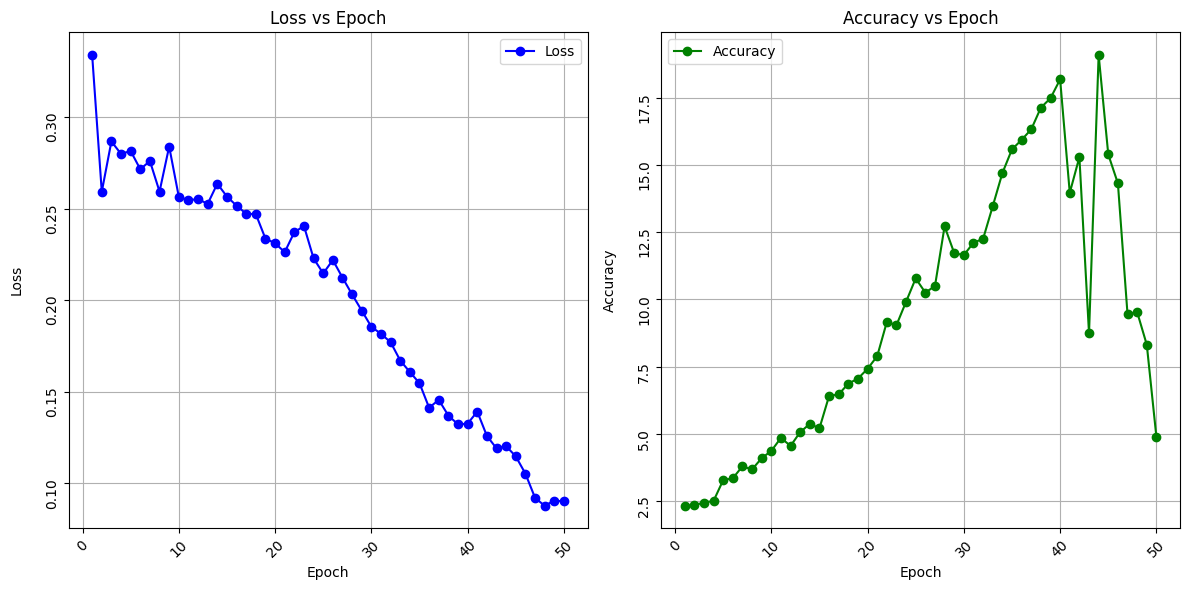

In [ ]:

# Plot Loss vs Epoch
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epoch_numbers, loss, marker='o', color='b', label='Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss', rotation=90, labelpad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.legend()
plt.grid(True)

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epoch_numbers, accuracy, marker='o', color='g', label='Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy', rotation=90, labelpad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
img_path = 'data/test/1399_jpg.rf.f181f781289594b01f09c963eec9064e.jpg' 

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image / 255.0
reshaped_image = image[np.newaxis, :, :]
tensor_img = torch.tensor(reshaped_image, dtype=torch.float32).to(device)
output = model([tensor_img])


In [ ]:
output

[{'boxes': tensor([[202.2045, 254.5716, 305.5206, 359.2991],
          [229.1791, 265.4216, 329.6694, 378.0959],
          [218.3996, 279.6322, 301.3525, 337.7260],
          [222.8978, 232.8377, 332.1390, 342.8056],
          [203.9719, 253.0887, 420.4486, 377.6304],
          [221.9796, 263.0989, 286.7166, 397.3443],
          [238.3593, 286.9632, 314.8545, 353.8142],
          [203.0825, 268.6080, 301.6605, 384.2378],
          [220.4089, 210.2777, 333.8502, 434.4609],
          [193.4177, 228.5096, 301.3665, 351.1874],
          [152.3429, 280.3590, 269.4759, 352.8548],
          [232.0943, 248.3060, 281.8532, 346.6659],
          [ 61.8822, 216.0330, 286.7492, 352.0929],
          [216.4929, 287.9322, 300.3192, 343.3179],
          [148.0135, 275.5817, 263.0855, 354.1679],
          [ 61.2704, 212.5011, 284.8200, 352.5204],
          [224.2467, 248.3125, 344.9626, 364.8936],
          [ 66.2851, 156.6094, 188.1120, 250.8079],
          [ 88.3258, 170.4649, 165.6590, 239.3947],
   

In [ ]:
output_score = output[0]

# Get the index of the bounding box with the highest score
max_score_index = torch.argmax(output_score['scores']).item()

# Get the bounding box and the label with the highest score
highest_score_bbox = output_score['boxes'][max_score_index]
highest_score_label = output_score['labels'][max_score_index]

# Print the results
print(f"Highest score bounding box: {highest_score_bbox}")
print(f"Corresponding label: {highest_score_label}")

Highest score bounding box: tensor([202.2045, 254.5716, 305.5206, 359.2991], device='cuda:0',
       grad_fn=<SelectBackward0>)
Corresponding label: 2


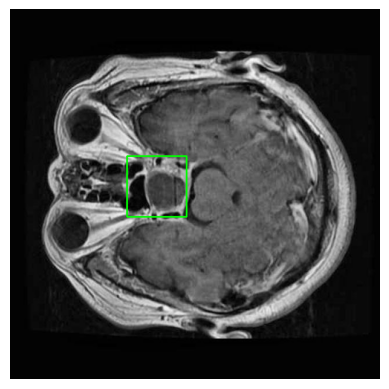

In [ ]:
output_scor = output[0]
image = image * 255.0
image = image.astype(np.uint8)

# Get the index of the bounding box with the highest score
max_score_index = torch.argmax(output_scor['scores']).item()

# Get the bounding box coordinates
highest_score_bbox = output_scor['boxes'][max_score_index].detach().cpu().numpy()

# Convert coordinates to integers
x1, y1, x2, y2 = map(int, highest_score_bbox)
color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Convert the image to RGB (from BGR) for Matplotlib
image_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

#[ 71.4827,  70.9767, 373.4568, 234.9165],
308,260,92.5,115
# Draw the bounding box on the image
cv2.rectangle(image_rgb, (x1,y1), (x2,y2), (0, 255, 0), 2)


# Display the image with the bounding box
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

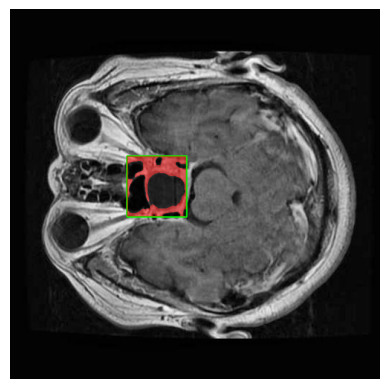

In [ ]:
roi = image_rgb[y1:y2, x1:x2]

# Convert the ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Apply the Chan-Vese segmentation algorithm
cv_result = chan_vese(roi_gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)

# Get the segmented mask
segmented_mask = cv_result[0]

# Invert the binary mask
inverted_mask = ~segmented_mask

# Convert the inverted mask to a 3D image with the same shape as the ROI
segmented_image = np.zeros_like(roi)
segmented_image[inverted_mask] = [255, 0, 0]  # Red color for the background region

# Overlay the segmented ROI back in the original image
overlay = cv2.addWeighted(roi, 0.5, segmented_image, 0.5, 0)
image_rgb[y1:y2, x1:x2] = overlay



# Display the image with the segmented ROI
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# 4 : Chan-Vese Algorithm for Segmentation

In [ ]:
image_folder = '/image_seg2/data/train'

# List all files in the directory
image_files = os.listdir(image_folder)

# Filter for image files 
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg'))]

# Read and process each image
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  


In [ ]:


def segment_tumor(image, bounding_box):
    x, y, w, h = bounding_box
    roi = image[y:y+h, x:x+w]
    cv = chan_vese(roi, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)
    return cv

# Example usage
bounding_box = [50, 50, 100, 100] 
segmented_image = segment_tumor(image, bounding_box)


In [ ]:
segmented_image

(array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 array([[ 0.00717884,  0.01271998,  0.01347814, ..., -0.02552251,
         -0.02559303, -0.02403628],
        [ 0.00724433,  0.01312757,  0.01433268, ..., -0.03859924,
         -0.05786947, -0.07243101],
        [ 0.00720376,  0.01287343,  0.01552945, ..., -0.0448975 ,
         -0.07149961, -0.08575576],
        ...,
        [-0.01055612, -0.03415536, -0.04430442, ...,  0.24351265,
          0.29226764,  0.31819594],
        [-0.01060455, -0.05556835, -0.07242012, ...,  0.29215562,
          0.3418204 ,  0.36690771],
        [-0.01027718, -0.07216913, -0.08781124, ...,  0.31786214,
          0.36677859,  0.38573854]]),
 [845.3843613827

# 5 : Evaluation Metrics

In [ ]:

def evaluate_segmentation(pred, true):
    pred_flat = pred.flatten()
    true_flat = true.flatten()
    return jaccard_score(true_flat, pred_flat)

# Example usage
true_mask = cv2.imread('path/to/true_mask.png', cv2.IMREAD_GRAYSCALE)
pred_mask = segmented_image.astype(np.uint8) * 255
score = evaluate_segmentation(pred_mask, true_mask)
print(f'Jaccard Score: {score}')
